In [1]:
import spotiphy
import numpy as np
import matplotlib as mpl
import squidpy as sq
import scanpy as sc
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
imp.reload(spotiphy)
imp.reload(spotiphy.sc_reference)

<module 'spotiphy.sc_reference' from 'C:\\Users\\zzheng92\\Desktop\\Spotiphy\\spotiphy\\sc_reference.py'>

In [2]:
# adata_sc = sc.read_h5ad("F:/Ziqian Zheng/Spotiphy_data/ATRT/SHHaS1_TB_14_3493_spatial1/raw_data/"
#                         "All_sample_sc_samplebysample.h5ad")
adata_sc = sc.read_h5ad('F:/Ziqian Zheng/Spotiphy_data/ATRT/Qingfei_opt_sc_samplebysample.h5ad')
adata_sc_copy = adata_sc.copy()
adata_st = sc.read_visium("F:/Ziqian Zheng/Spotiphy_data/ATRT/SHHaS1_TB_14_3493_spatial1/raw_data/outs")
adata_st.var_names_make_unique()
results_folder = 'results/ATRT/SHHaS1_TB_14_3493/'
key_type = 'cellType_xy2'
type_list = sorted(list(adata_sc.obs[key_type].unique()))

anndata.py (1832): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
gene_list = adata_sc.var_names
select = np.array([True]*len(gene_list))
for i, gene in enumerate(gene_list):
    if "MT" in gene or "mt" in gene or "RPL" in gene or "RPS" in gene:
        select[i] = False
adata_sc = adata_sc[:, select]

In [4]:
# adata_sc.obs['nCount_RNA'] = np.sum(adata_sc.X, axis=1)

594719476.py (1): Trying to modify attribute `.obs` of view, initializing view as actual.


In [5]:
# type_annotation = adata_sc.obs['celltype'].values
# for i, type_ in enumerate(type_annotation):
#     if type_[-4:-1] == 'MYC':
#         adata_sc.obs['celltype'][i] = 'MYC'
#     elif type_[-4:-1] == 'TYR':
#         adata_sc.obs['celltype'][i] = 'TYR'
#     elif type_[-5:-1] == 'SHHa':
#         adata_sc.obs['celltype'][i] = 'SHHa'
#     elif type_[-5:-1] == 'SHHb':
#         adata_sc.obs['celltype'][i] = 'SHHb'

In [6]:
# key_type = 'celltype'
# type_list = sorted(list(adata_sc.obs[key_type].unique()))
# type_list

In [4]:
%%time
adata_sc, adata_st = spotiphy.initialization(adata_sc, adata_st, filtering=False)

CPU times: total: 10min 45s
Wall time: 10min 47s


In [5]:
%%time
marker_gene_dict = spotiphy.sc_reference.marker_selection(adata_sc, key_type=key_type, return_dict=True, n_select=30, R=1.5)
marker_gene = []
marker_gene_label = []
for type_ in type_list:
    marker_gene.extend(marker_gene_dict[type_])
    marker_gene_label.extend([type_]*len(marker_gene_dict[type_]))
marker_gene_df = pd.DataFrame({'gene':marker_gene, 'label':marker_gene_label})
print(len(marker_gene))
# np.save('results/ATRT/Jun 12/marker3.npy', np.array(marker_gene))

777
CPU times: total: 6min 2s
Wall time: 6min 3s


In [6]:
marker_gene_tumor = pd.read_csv('results/ATRT/Jun 12/top30_byPctDiff.txt', header=0, delimiter='\t')
marker_gene_tumor = list(marker_gene_tumor['Marker'])
marker_gene_tumor = [gene for gene in marker_gene_tumor if gene in adata_sc.var_names]
non_tumor_type = ['Astrocytes', 'BMDM', 'Dopaminergic', 'Fibroblast_like', 'GABAergic', 'Glutamatergic', 'Microglia', 'OLs', 'Pre_OLs']
marker_gene_nontumor = []
for type_ in non_tumor_type:
    marker_gene_nontumor.extend(marker_gene_dict[type_])
marker_gene_nontumor = [gene for gene in marker_gene_nontumor if gene not in marker_gene_tumor]
marker_gene = marker_gene_tumor + marker_gene_nontumor
marker_gene = list(dict.fromkeys(marker_gene))

In [7]:
adata_sc = adata_sc[:, marker_gene]
adata_st = adata_st[:, marker_gene]

In [8]:
%%time
sc_ref = spotiphy.construct_sc_ref(adata_sc, key_type=key_type)

CPU times: total: 2min
Wall time: 2min


In [19]:
# sc_ref_sort = np.sort(sc_ref, axis=0)
# select = sc_ref_sort[-1] > 1.5 * sc_ref_sort[-2]
# print(np.sum(select))
# adata_sc = adata_sc[:, select]
# adata_st = adata_st[:, select]

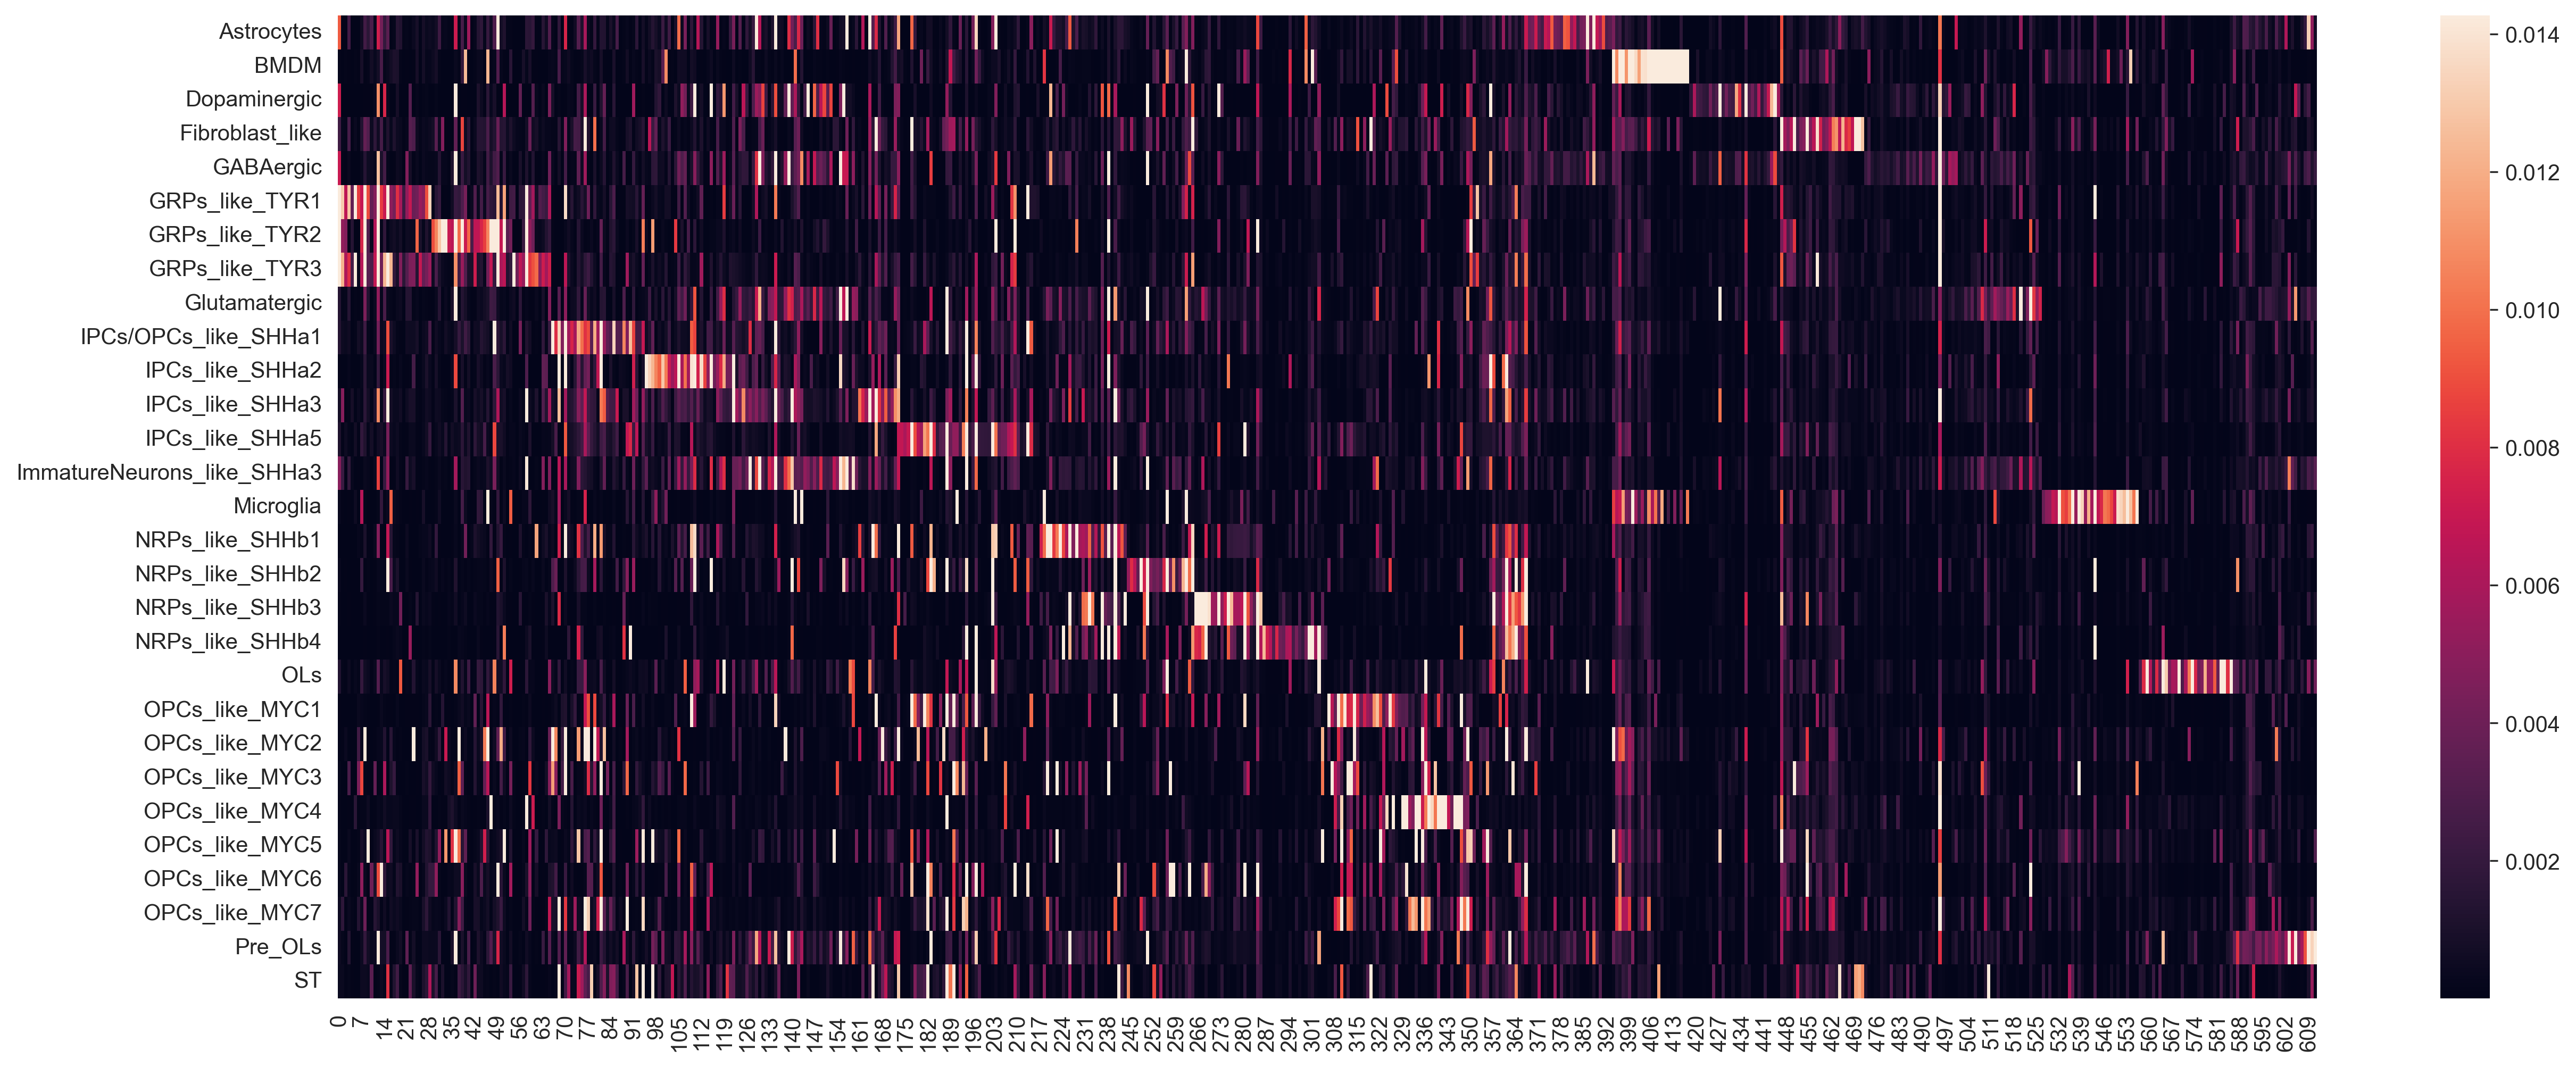

In [9]:
ST = adata_st.X
ST = np.sum(ST, axis=0)
ST = ST/np.sum(ST)
plt.figure(figsize=(20,8), dpi=300)
sc_ref_df = pd.DataFrame(np.vstack([sc_ref, ST]), index=type_list+['ST'])
ax = sns.heatmap(sc_ref_df, robust=True)
plt.savefig(results_folder+'heatmap_marker1.png', dpi=1000)
# ax.set_xticklabels(marker_gene, rotation=90)

In [9]:
# marker_gene_df['ST'] = ST
# marker_gene_df = marker_gene_df.sort_values(by='ST', ascending=False)
# marker_gene_df.to_csv(results_folder+'ATRT_marker.csv')
# marker_gene_df

,gene,label,ST
732,VIM,OPCs_like_MYC5,0.085424
718,MDK,OPCs_like_MYC5,0.045173
734,GNAS,OPCs_like_MYC5,0.024421
247,MIAT,Glutamatergic,0.021507
361,MARCKS,IPCs_like_SHHa5,0.020275
...,...,...,...
508,PCDH9-AS2,NRPs_like_SHHb3,0.000000
512,AP000462.1,NRPs_like_SHHb3,0.000000
521,LINC02643,NRPs_like_SHHb3,0.000000
711,LINC02672,OPCs_like_MYC4,0.000000


In [10]:
%%time
X = np.array(adata_st.X)
pyro_params = spotiphy.deconvolution.deconvolute(X, sc_ref, n_epoch=10000)
sigma = pyro_params['sigma'].cpu().detach().numpy()
mean_exp = np.array([np.mean(np.sum(adata_sc.X[adata_sc.obs[key_type]==type_list[i]], axis=1)) for i in range(len(type_list))])
cell_proportion = sigma/mean_exp
cell_proportion = cell_proportion/np.sum(cell_proportion, axis=1)[:, np.newaxis]
adata_st.obs[type_list] = cell_proportion

 55%|█████▍    | 5469/10000 [02:51<02:01, 37.40it/s]

In [26]:
# mean_total_count = adata_sc_copy.obs.groupby('celltype')['nCount_RNA'].mean().values
# cell_proportion = sigma/mean_exp/mean_total_count
# cell_proportion = cell_proportion/np.sum(cell_proportion, axis=1)[:, np.newaxis]
# adata_st.obs[type_list] = cell_proportion

In [12]:
adata_st.var.rename(index={'TYR': 'TYR_g'}, inplace=True)
with mpl.rc_context({'figure.figsize': [4, 4.5], 'figure.dpi': 400}):
    ax = sc.pl.spatial(adata_st, cmap='magma', color=type_list, img_key=None, vmin=0, vmax='p98', ncols=5, size=1.5, show=False)
    ax[0].get_figure().savefig(results_folder+'spotiphy_marker1.jpg')

In [15]:
print({k:v for k, v in zip(np.sum(cell_proportion, axis=0), type_list)})

{31.806914916199418: 'Astrocytes', 43.97832431344631: 'BMDM', 56.916415832979354: 'Dopaminergic', 37.27904075711258: 'Fibroblast_like', 37.51237410754673: 'GABAergic', 35.88786551603409: 'GRPs_like_TYR1', 49.63306606073331: 'GRPs_like_TYR2', 40.9375839173739: 'GRPs_like_TYR3', 39.43679009592005: 'Glutamatergic', 39.71343418871185: 'IPCs/OPCs_like_SHHa1', 27.368638476201617: 'IPCs_like_SHHa2', 33.250595044250296: 'IPCs_like_SHHa3', 51.559017996572436: 'IPCs_like_SHHa5', 36.777943750487836: 'ImmatureNeurons_like_SHHa3', 46.713914156958836: 'Microglia', 32.03873943874286: 'NRPs_like_SHHb1', 41.754158014064075: 'NRPs_like_SHHb2', 59.12299219063563: 'NRPs_like_SHHb3', 37.70488805777663: 'NRPs_like_SHHb4', 37.529369298838745: 'OLs', 42.56973881684246: 'OPCs_like_MYC1', 61.93820626238323: 'OPCs_like_MYC2', 49.26580750176317: 'OPCs_like_MYC3', 46.8348873110724: 'OPCs_like_MYC4', 42.886245698103615: 'OPCs_like_MYC5', 35.52133075600197: 'OPCs_like_MYC6', 69.26255130685743: 'OPCs_like_MYC7', 30.7

In [15]:
adata_sc_copy.obs.groupby('cellType_xy2')['nCount_RNA'].mean()

cellType_xy2
Astrocytes                     6645.151534
BMDM                           1387.694762
Dopaminergic                   4654.943651
Fibroblast_like                5192.161994
GABAergic                     10704.067913
GRPs_like_TYR1                 7368.970683
GRPs_like_TYR2                10821.340146
GRPs_like_TYR3                 3939.850389
Glutamatergic                  9179.193401
IPCs/OPCs_like_SHHa1           7974.790374
IPCs_like_SHHa2                7581.748660
IPCs_like_SHHa3                3177.327684
IPCs_like_SHHa5                6846.808094
ImmatureNeurons_like_SHHa3     8217.713557
Microglia                      3355.614879
NRPs_like_SHHb1                7426.866187
NRPs_like_SHHb2                9808.312682
NRPs_like_SHHb3                6115.491693
NRPs_like_SHHb4               11281.421027
OLs                            5121.689338
OPCs_like_MYC1                10439.662101
OPCs_like_MYC2                 6903.370459
OPCs_like_MYC3                 6134.01487